In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import make_scorer

In [3]:
df = pd.read_csv('/gdrive/My Drive/DS_contest/Beforelasso.csv')
df.head(5)

,Unnamed: 0,No,MD (All Wells) (ft),TVD (ft),Bot-Hole direction (N/S)/(E/W),Bot-Hole Easting (NAD83),Bot-Hole Northing (NAD83),Total Proppant Placed (tonne),Avg Proppant Placed per Stage (tonne),Total Fluid Pumped (m3),Avg Fluid Pumped per Stage (m3),Stages Actual,Completed Length (m),Avg Frac Spacing (m),Load Fluid Rec (m3),Load Fluid (m3),Avg Fluid Pumped / Meter (m3),Avg Proppant Placed / Meter (tonne),Proppant Size 1,Avg Proppant 1 Placed (tonne),Total Proppant 1 Placed (tonne),Total Ceramic Proppant Placed (tonne),Total Sand Proppant Placed (tonne),Y_first6,SF_oil,SF_water,SF_slickwater,PC_ceramic,PC_sand
0,0,354,15384,10746,0.583087,0.520701,0.202393,1197.61,66.53,3214.70,178.59,18,1249.60,73.50,1148.37,3248.30,2.57,0.96,40.0,35.48,638.70,638.70,558.91,99580.58333,1,0,0,1,0
1,1,372,20167,10440,1.059932,0.402927,0.242269,4212.32,117.01,9727.20,270.20,36,2711.90,77.41,1604.27,11438.43,3.59,1.55,60.0,13.80,496.97,496.97,3715.35,82942.66667,0,1,0,1,0
2,2,383,18832,10745,1.913723,0.351151,0.274381,5131.40,95.03,52997.80,981.44,54,2275.37,42.88,914.98,52997.80,23.29,2.26,55.0,95.03,5131.40,0.00,5131.40,55833.66667,0,1,0,0,1
3,3,395,20243,10884,0.185481,0.231014,0.305237,3044.00,49.90,42791.76,701.50,61,2687.20,43.04,0.00,51059.60,15.92,1.13,55.0,49.90,3044.00,0.00,3044.00,95592.08333,0,1,0,0,1
4,4,397,19085,10916,0.432910,0.214301,0.306795,5374.00,99.52,50769.92,940.18,54,2351.45,42.70,0.00,53236.05,21.59,2.29,55.0,99.09,5351.00,0.00,5374.00,104730.33330,0,1,0,0,1


In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.columns

Index(['No', 'MD (All Wells) (ft)', 'TVD (ft)',
       'Bot-Hole direction (N/S)/(E/W)', 'Bot-Hole Easting (NAD83)',
       'Bot-Hole Northing (NAD83)', 'Total Proppant Placed (tonne)',
       'Avg Proppant Placed per Stage (tonne)', 'Total Fluid Pumped (m3)',
       'Avg Fluid Pumped per Stage (m3)', 'Stages Actual',
       'Completed Length (m)', 'Avg Frac Spacing (m)', 'Load Fluid Rec (m3)',
       'Load Fluid (m3)', 'Avg Fluid Pumped / Meter (m3)',
       'Avg Proppant Placed / Meter (tonne)', 'Proppant Size 1',
       'Avg Proppant 1 Placed (tonne)', 'Total Proppant 1 Placed (tonne)',
       'Total Ceramic Proppant Placed (tonne)',
       'Total Sand Proppant Placed (tonne)', 'Y_first6', 'SF_oil', 'SF_water',
       'SF_slickwater', 'PC_ceramic', 'PC_sand'],
      dtype='object')

In [6]:
df_std = df.drop(['No','SF_oil','SF_water','SF_slickwater','PC_ceramic','PC_sand','Y_first6'],axis=1)
df_normal = df.drop(['No','SF_oil','SF_water','SF_slickwater','PC_ceramic','PC_sand','Y_first6'],axis=1)

In [7]:
def feature_scaling(df, scaling_strategy="z-score", column=None):
    if column == None:
        column = [column_name for column_name in df.columns]
    for column_name in column:
        if scaling_strategy == "min-max":
            df[column_name] = ( df[column_name] - df[column_name].min() ) /\
                            (df[column_name].max() - df[column_name].min()) 
        elif scaling_strategy == "z-score":
            df[column_name] = ( df[column_name] - \
                               df[column_name].mean() ) /\
                            (df[column_name].std() )
    return df

In [8]:
df_std = feature_scaling(df_std)
df_normal = feature_scaling(df_normal, scaling_strategy = 'min-max')
df_std.head(5), df_normal.head(5)

(   MD (All Wells) (ft)  ...  Total Sand Proppant Placed (tonne)
 0            -1.562520  ...                           -2.107496
 1             0.933927  ...                           -0.464036
 2             0.237135  ...                            0.273257
 3             0.973595  ...                           -0.813587
 4             0.369186  ...                            0.399571
 
 [5 rows x 21 columns],
    MD (All Wells) (ft)  ...  Total Sand Proppant Placed (tonne)
 0             0.152973  ...                            0.016260
 1             0.749283  ...                            0.345439
 2             0.582845  ...                            0.493116
 3             0.758758  ...                            0.275425
 4             0.614387  ...                            0.518416
 
 [5 rows x 21 columns])

In [9]:
df_std['No'] = df['No']
df_std['SF_oil'] = df['SF_oil']
df_std['SF_water'] = df['SF_water']
df_std['SF_slickwater'] = df['SF_slickwater']
df_std['PC_ceramic'] = df['PC_ceramic']
df_std['PC_sand'] = df['PC_sand']
df_std['Y_first6'] = df['Y_first6']
df_normal['No'] = df['No']
df_normal['SF_oil'] = df['SF_oil']
df_normal['SF_water'] = df['SF_water']
df_normal['SF_slickwater'] = df['SF_slickwater']
df_normal['PC_ceramic'] = df['PC_ceramic']
df_normal['PC_sand'] = df['PC_sand']
df_normal['Y_first6'] = df['Y_first6']

Lasso (Feature selection)

In [10]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
x_std = df_std.drop(['No','Y_first6'],axis=1)
x_normal = df_normal.drop(['No','Y_first6'],axis=1)
y = df['Y_first6']
lasso_reg = Lasso(alpha=350, normalize=False)

In [34]:
import numpy as np
from sklearn.metrics import make_scorer

def sMAPE(actual_values, predicted_values, expsMAPE = False):
  '''
  logY를 regression하는 경우에 expsMAPE = True로 입력, 아니면 expsMAPE = False로 놔두면 됨
  reg_sMAPE = GridSearchCV(RandomForestRegressor(), {}, scoring=make_scorer(sMAPE, greater_is_better=False)) 이런식으로 쓰면됨
  reg_sMAPE.fit(x,y)
  '''
  if expsMAPE == True:
    predicted_values = np.exp(predicted_values)
    actual_values = np.exp(actual_values)
  return 1/len(actual_values) * np.sum(2*np.abs(actual_values - predicted_values) / (np.abs(actual_values) + np.abs(predicted_values)) * 100)

In [12]:
reg_sMAPE = GridSearchCV(Lasso(), {}, scoring=make_scorer(sMAPE, greater_is_better=False),cv=5)
reg_sMAPE.fit(x_std,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e+11, tolerance: 6.139e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default va

GridSearchCV(cv=5, estimator=Lasso(normalize=False), param_grid={},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [13]:
#feature selection
x_std_train, x_std_test, y_std_train, y_std_test = train_test_split(x_std, y, test_size = 0.2, random_state = 34)
std_pred = lasso_reg.fit(x_std_train, y_std_train)
y_std_pred = lasso_reg.predict(x_std_test)
lasso_reg.coef_, lasso_reg.intercept_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


(array([-0.00000000e+00,  1.06622383e+04,  2.52267935e+02,  0.00000000e+00,
        -1.33157818e+04,  3.26917224e+04, -1.24787137e+04,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -4.97254400e+03,  1.15523001e+04,
        -0.00000000e+00, -3.79430397e+03, -3.51589317e+03, -0.00000000e+00,
        -2.84155491e+03, -0.00000000e+00,  6.42825469e+03,  8.83790261e+03,
         0.00000000e+00, -3.33741442e+04, -0.00000000e+00,  3.95837311e+03,
        -7.84264340e+02,  1.14039499e-12]), 81071.54032497448)

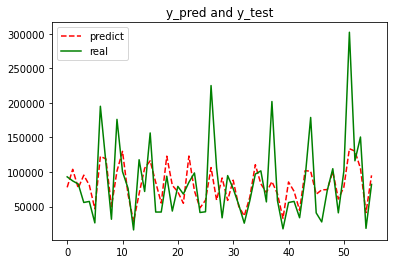

In [ ]:
index_list = np.arange(len(y_std_pred))
plt.plot(index_list, y_std_pred, '--', c='r', label = 'predict')
plt.plot(index_list, y_std_test, '-', c='g', label = 'real')
plt.title('y_pred and y_test')
plt.legend()

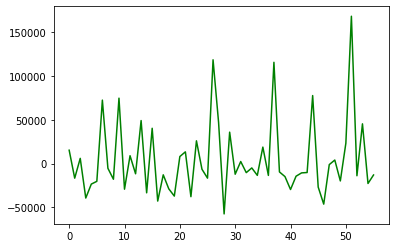

In [ ]:
plt.plot(index_list, y_std_test - y_std_pred, '-', c='g', label = 'std_residual')

In [15]:
'''
def sMAPE(a, f):
  return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
def mse_over_billion(a, f):
  return np.mean((a-f)**2) / 1000000000
'''

In [ ]:
print(sMAPE(y_std_pred,y_std_test))
print(mse_over_billion(y_std_pred,y_std_test))

Min-Max normalization은 확실히 별로임. Standardization으로 해야할듯.

In [ ]:
''' 선택한 features: 
'TVD (ft)', 'Bot-Hole Northing (NAD83)', 'Total Proppant Placed (tonne)', 'Avg Proppant Placed per Stage (tonne)', 
'Avg Fluid Pumped per Stage (m3)', 'Stages Actual', 'Avg Frac Spacing (m)', 'Avg Fluid Pumped / Meter (m3)',
'Proppant Size 1', 'Total Ceramic Proppant Placed (tonne)', 'SF_oil', 'SF_slickwater' '''

" 선택한 features: \n'TVD (ft)', 'Bot-Hole Northing (NAD83)', 'Total Proppant Placed (tonne)', 'Avg Proppant Placed per Stage (tonne)', \n'Avg Fluid Pumped per Stage (m3)', 'Stages Actual', 'Avg Frac Spacing (m)', 'Avg Fluid Pumped / Meter (m3)',\n'Proppant Size 1', 'Total Ceramic Proppant Placed (tonne)', 'SF_oil', 'SF_slickwater' "

Lasso

In [107]:
from sklearn.linear_model import Lasso
x_std = df_std.drop(['No','Y_first6'],axis=1)
y = df['Y_first6']

In [115]:
alpha_list = {'alpha' : np.arange(2602,2608,0.1)}
reg_sMAPE = GridSearchCV(Lasso(), param_grid = alpha_list, scoring=make_scorer(sMAPE, greater_is_better=False),cv=5)
reg_sMAPE.fit(x_std,y)
print('최적의 parameter: ', reg_sMAPE.best_params_)

최적의 parameter:  {'alpha': 2604.9999999999973}


In [116]:
lasso_opt = Lasso(alpha=2605).fit(x_std,y)
y_pred = lasso_opt.predict(x_std)
print(sMAPE(y, y_pred, False))

38.8852060130452


In [119]:
std_pred = lasso_opt.fit(x_std, y)
y_pred = lasso_opt.predict(x_std)
lasso_opt.coef_, lasso_opt.intercept_

(array([     0.        ,   7656.03943888,      0.        ,     -0.        ,
        -14358.76166948,  17905.97814925,      0.        ,     -0.        ,
           -55.81911323,      0.        ,      0.        ,   2520.87328507,
             0.        ,     -0.        ,     -0.        ,      0.        ,
         -2037.66242272,      0.        ,      0.        ,      0.        ,
             0.        ,     -0.        ,      0.        ,      0.        ,
            -0.        ,      0.        ]), 79291.4431524893)

In [120]:
x_std.columns

Index(['MD (All Wells) (ft)', 'TVD (ft)', 'Bot-Hole direction (N/S)/(E/W)',
       'Bot-Hole Easting (NAD83)', 'Bot-Hole Northing (NAD83)',
       'Total Proppant Placed (tonne)',
       'Avg Proppant Placed per Stage (tonne)', 'Total Fluid Pumped (m3)',
       'Avg Fluid Pumped per Stage (m3)', 'Stages Actual',
       'Completed Length (m)', 'Avg Frac Spacing (m)', 'Load Fluid Rec (m3)',
       'Load Fluid (m3)', 'Avg Fluid Pumped / Meter (m3)',
       'Avg Proppant Placed / Meter (tonne)', 'Proppant Size 1',
       'Avg Proppant 1 Placed (tonne)', 'Total Proppant 1 Placed (tonne)',
       'Total Ceramic Proppant Placed (tonne)',
       'Total Sand Proppant Placed (tonne)', 'SF_oil', 'SF_water',
       'SF_slickwater', 'PC_ceramic', 'PC_sand'],
      dtype='object')

Log Lasso

In [121]:
import math
log_list = []
for i in df_std['Y_first6']:
  log_list.append(math.log(i))

x_std = df_std.drop(['No','Y_first6'],axis=1)
y = log_list

In [128]:
alpha_list = {'alpha' : np.arange(0.02,0.04,0.001)}
reg_sMAPE = GridSearchCV(Lasso(), param_grid = alpha_list, scoring=make_scorer(expsMAPE, greater_is_better=False), cv=5)
reg_sMAPE.fit(x_std,y)
print('최적의 parameter: ', reg_sMAPE.best_params_)

최적의 parameter:  {'alpha': 0.03100000000000001}


In [129]:
loglasso_opt = Lasso(alpha=0.031).fit(x_std,y)
y_pred = loglasso_opt.predict(x_std)
print(sMAPE(y, y_pred, True))

36.86207494742843


In [130]:
loglasso_opt.coef_, loglasso_opt.intercept_

(array([ 0.        ,  0.0931455 ,  0.        , -0.        , -0.18441377,
         0.22091997,  0.        , -0.        , -0.00688338,  0.        ,
         0.06137183,  0.03564248,  0.        , -0.        , -0.        ,
         0.        , -0.00207498,  0.        ,  0.        ,  0.        ,
         0.        , -0.        ,  0.        ,  0.        , -0.        ,
         0.        ]), 11.09557738166954)

Ridge

In [74]:
dfdf

,TVD (ft),Bot-Hole Northing (NAD83),Total Proppant Placed (tonne),Avg Proppant Placed per Stage (tonne),Avg Fluid Pumped per Stage (m3),Stages Actual,Avg Frac Spacing (m),Avg Fluid Pumped / Meter (m3),Proppant Size 1,Total Ceramic Proppant Placed (tonne),No,SF_oil,SF_slickwater,Y_first6
0,1.226824,-0.858988,-1.961185,-1.522041,-1.299002,-1.281383,0.244388,-1.141268,-1.393265,2.901430,354,1,0,99580.58333
1,0.490518,-0.628932,-0.273031,-0.287012,-1.082439,-0.110788,0.415743,-1.026866,0.587010,2.152315,372,0,0,82942.66667
2,1.224418,-0.443670,0.241628,-0.824768,0.598911,1.059806,-1.097524,1.182662,0.091941,-0.474427,383,0,0,55833.66667
3,1.558884,-0.265648,-0.927258,-1.928906,-0.062859,1.515038,-1.090512,0.356052,0.091941,-0.474427,395,0,0,95592.08333
4,1.635883,-0.256663,0.377477,-0.714917,0.501373,1.059806,-1.105412,0.991992,0.091941,-0.474427,397,0,0,104730.33330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.276364,1.106074,0.845244,0.745442,1.002558,0.084311,-0.031707,0.470454,0.091941,-0.474427,708,0,0,43417.00000
276,-0.481598,1.365615,0.057408,0.766727,-1.052605,-0.500987,1.678332,-1.125566,0.091941,-0.474427,716,0,0,46754.00000
277,-0.298725,1.125113,-0.170568,-0.162726,-0.736141,-0.110788,0.609886,-0.849655,0.091941,-0.474427,718,0,0,20921.00000
278,-0.043664,1.141927,-0.155112,-0.058013,-1.075134,-0.175822,0.612516,-1.060513,0.091941,-0.474427,720,0,0,56508.16667


In [73]:
dfdf = pd.read_csv('/gdrive/My Drive/DS_contest/Finaldata1.csv')
dfdf = dfdf.drop('Unnamed: 0',axis=1)

In [75]:
from sklearn.linear_model import Ridge
x_std = dfdf.drop(['No','Y_first6'],axis=1)
y = dfdf['Y_first6']

In [79]:
alpha_list = {'alpha' : np.arange(100,105,0.1)}
reg_sMAPE = GridSearchCV(Ridge(), param_grid = alpha_list, scoring=make_scorer(sMAPE, greater_is_better=False),cv=5)
reg_sMAPE.fit(x_std,y)
print('최적의 parameter: ', reg_sMAPE.best_params_)

최적의 parameter:  {'alpha': 102.29999999999987}


In [80]:
ridge_opt = Ridge(alpha=102.3).fit(x_std,y)
y_pred = ridge_opt.predict(x_std)
print(sMAPE(y, y_pred, False))

38.60243721018413


Log Ridge

In [85]:
def expsMAPE(actual_values, predicted_values, expsMAPE = True):
  predicted_values = np.exp(predicted_values)
  actual_values = np.exp(actual_values)
  return 1/len(actual_values) * np.sum(2*np.abs(actual_values - predicted_values) / (np.abs(actual_values) + np.abs(predicted_values)) * 100)

In [81]:
log_list = []
for i in dfdf['Y_first6']:
  log_list.append(math.log(i))

x_std = dfdf.drop(['No','Y_first6'],axis=1)
y = log_list

In [88]:
alpha_list = {'alpha' : np.arange(0.05,0.5,0.01)}
reg_sMAPE = GridSearchCV(Ridge(), param_grid = alpha_list, scoring=make_scorer(expsMAPE, greater_is_better=False), cv=5)
reg_sMAPE.fit(x_std,y)
print('최적의 parameter: ', reg_sMAPE.best_params_)

최적의 parameter:  {'alpha': 0.2}


In [89]:
logridge_opt = Ridge(alpha=0.2).fit(x_std,y)
y_pred = logridge_opt.predict(x_std)
print(sMAPE(y, y_pred, True))

35.83408269845744


Robust Regression (안함)

In [ ]:
from sklearn.linear_model import RANSACRegressor
x_std = df_std.drop(['No','Y_first6'],axis=1)
y = df['Y_first6']

In [ ]:
reg_sMAPE = GridSearchCV(RANSACRegressor(), {}, scoring=make_scorer(sMAPE, greater_is_better=False))
reg_sMAPE.fit(x_std,y)
y_pred = reg_sMAPE.predict(x_std)
print(sMAPE(y, y_pred, False))

55.416019269604334


Log Robust Regression (안함)

In [ ]:
log_list = []
for i in df_std['Y_first6']:
  log_list.append(math.log(i))

x_std = df_std.drop(['No','Y_first6'],axis=1)
y = log_list

In [ ]:
reg_sMAPE = GridSearchCV(RANSACRegressor(), {}, scoring=make_scorer(sMAPE, greater_is_better=False))
reg_sMAPE.fit(x_std,y)
y_pred = reg_sMAPE.predict(x_std)
print(sMAPE(y, y_pred, True))

58.60719943646769


Elastic Net

In [90]:
from sklearn.linear_model import ElasticNet
x_std = df_std.drop(['No','Y_first6'],axis=1)
y = df['Y_first6']

In [97]:
param_list = {'alpha' : np.arange(4,8,0.1), 'l1_ratio' : np.arange(0, 1.1, 0.1)}

reg_sMAPE = GridSearchCV(ElasticNet(), param_grid = param_list, scoring=make_scorer(sMAPE, greater_is_better=False), cv=5)
reg_sMAPE.fit(x_std,y)
print('최적의 parameter: ', reg_sMAPE.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.659e+11, tolerance: 6.139e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.422e+11, tolerance: 5.407e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

최적의 parameter:  {'alpha': 6.79999999999999, 'l1_ratio': 0.9}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.253e+11, tolerance: 6.139e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.253e+08, tolerance: 5.407e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

In [99]:
elastic_opt = ElasticNet(alpha=6.8, l1_ratio = 0.9).fit(x_std,y)
y_pred = elastic_opt.predict(x_std)
print(sMAPE(y, y_pred, False))

38.92396130449107


Log ElasticNet

In [100]:
log_list = []
for i in df_std['Y_first6']:
  log_list.append(math.log(i))

x_std = df_std.drop(['No','Y_first6'],axis=1)
y = log_list

In [104]:
alpha_list = {'alpha' : np.arange(0.02,0.04,0.001), 'l1_ratio' : np.arange(0, 1.1, 0.1) }
reg_sMAPE = GridSearchCV(ElasticNet(), param_grid = alpha_list, scoring=make_scorer(expsMAPE, greater_is_better=False), cv=5)
reg_sMAPE.fit(x_std,y)
print('최적의 parameter: ', reg_sMAPE.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.610e+01, tolerance: 1.001e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+01, tolerance: 8.321e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

최적의 parameter:  {'alpha': 0.03100000000000001, 'l1_ratio': 1.0}


In [105]:
logelastic_opt = ElasticNet(alpha=0.031, l1_ratio = 1).fit(x_std,y)
y_pred = logelastic_opt.predict(x_std)
print(sMAPE(y, y_pred, True))

36.86207494742843


Finaldata1.csv 생성

In [ ]:
df.head(3)

,No,MD (All Wells) (ft),TVD (ft),Bot-Hole direction (N/S)/(E/W),Bot-Hole Easting (NAD83),Bot-Hole Northing (NAD83),Total Proppant Placed (tonne),Avg Proppant Placed per Stage (tonne),Total Fluid Pumped (m3),Avg Fluid Pumped per Stage (m3),Stages Actual,Completed Length (m),Avg Frac Spacing (m),Load Fluid Rec (m3),Load Fluid (m3),Avg Fluid Pumped / Meter (m3),Avg Proppant Placed / Meter (tonne),Proppant Size 1,Avg Proppant 1 Placed (tonne),Total Proppant 1 Placed (tonne),Total Ceramic Proppant Placed (tonne),Total Sand Proppant Placed (tonne),Y_first6,SF_oil,SF_water,SF_slickwater,PC_ceramic,PC_sand
0,354,15384,10746,0.583087,0.520701,0.202393,1197.61,66.53,3214.7,178.59,18,1249.60,73.50,1148.37,3248.30,2.57,0.96,40.0,35.48,638.70,638.70,558.91,99580.58333,1,0,0,1,0
1,372,20167,10440,1.059932,0.402927,0.242269,4212.32,117.01,9727.2,270.20,36,2711.90,77.41,1604.27,11438.43,3.59,1.55,60.0,13.80,496.97,496.97,3715.35,82942.66667,0,1,0,1,0
2,383,18832,10745,1.913723,0.351151,0.274381,5131.40,95.03,52997.8,981.44,54,2275.37,42.88,914.98,52997.80,23.29,2.26,55.0,95.03,5131.40,0.00,5131.40,55833.66667,0,1,0,0,1


In [ ]:
dataframe = df_std.drop(['MD (All Wells) (ft)', 'Bot-Hole direction (N/S)/(E/W)', 'Bot-Hole Easting (NAD83)', 
         'Total Fluid Pumped (m3)', 'Completed Length (m)', 'Load Fluid Rec (m3)', 'Load Fluid (m3)',
         'Avg Proppant Placed / Meter (tonne)', 'Avg Proppant 1 Placed (tonne)', 'Total Proppant 1 Placed (tonne)', 
         'Total Sand Proppant Placed (tonne)', 'SF_water', 'PC_ceramic', 'PC_sand'], axis=1)

In [ ]:
dataframe.to_csv('/gdrive/My Drive/DS_contest/Finaldata1.csv')

In [ ]:
dataframe['new'] = dataframe['Y_first6']
dataframe = dataframe.drop('Y_first6',axis=1)
dataframe.rename(columns={'new':'Y_first6'},inplace=True)
dataframe.head(3)

,TVD (ft),Bot-Hole Northing (NAD83),Total Proppant Placed (tonne),Avg Proppant Placed per Stage (tonne),Avg Fluid Pumped per Stage (m3),Stages Actual,Avg Frac Spacing (m),Avg Fluid Pumped / Meter (m3),Proppant Size 1,Total Ceramic Proppant Placed (tonne),No,SF_oil,SF_slickwater,Y_first6
0,1.226824,-0.858988,-1.961185,-1.522041,-1.299002,-1.281383,0.244388,-1.141268,-1.393265,2.901430,354,1,0,99580.58333
1,0.490518,-0.628932,-0.273031,-0.287012,-1.082439,-0.110788,0.415743,-1.026866,0.587010,2.152315,372,0,0,82942.66667
2,1.224418,-0.443670,0.241628,-0.824768,0.598911,1.059806,-1.097524,1.182662,0.091941,-0.474427,383,0,0,55833.66667


다시

In [ ]:
dataframe = pd.read_csv('/gdrive/My Drive/DS_contest/Finaldata1.csv')

In [ ]:
dataframe.head(3)

,TVD (ft),Bot-Hole Northing (NAD83),Total Proppant Placed (tonne),Avg Proppant Placed per Stage (tonne),Avg Fluid Pumped per Stage (m3),Stages Actual,Avg Frac Spacing (m),Avg Fluid Pumped / Meter (m3),Proppant Size 1,Total Ceramic Proppant Placed (tonne),No,SF_oil,SF_slickwater,Y_first6
0,1.226824,-0.858988,-1.961185,-1.522041,-1.299002,-1.281383,0.244388,-1.141268,-1.393265,2.901430,354,1,0,99580.58333
1,0.490518,-0.628932,-0.273031,-0.287012,-1.082439,-0.110788,0.415743,-1.026866,0.587010,2.152315,372,0,0,82942.66667
2,1.224418,-0.443670,0.241628,-0.824768,0.598911,1.059806,-1.097524,1.182662,0.091941,-0.474427,383,0,0,55833.66667


In [ ]:
df_std.head(3)

,MD (All Wells) (ft),TVD (ft),Bot-Hole direction (N/S)/(E/W),Bot-Hole Easting (NAD83),Bot-Hole Northing (NAD83),Total Proppant Placed (tonne),Avg Proppant Placed per Stage (tonne),Total Fluid Pumped (m3),Avg Fluid Pumped per Stage (m3),Stages Actual,Completed Length (m),Avg Frac Spacing (m),Load Fluid Rec (m3),Load Fluid (m3),Avg Fluid Pumped / Meter (m3),Avg Proppant Placed / Meter (tonne),Proppant Size 1,Avg Proppant 1 Placed (tonne),Total Proppant 1 Placed (tonne),Total Ceramic Proppant Placed (tonne),Total Sand Proppant Placed (tonne),No,SF_oil,SF_water,SF_slickwater,PC_ceramic,PC_sand,Y_first6
0,-1.562520,1.226824,-0.247911,-0.248694,-0.858988,-1.961185,-1.522041,-1.368958,-1.299002,-1.281383,-1.848096,0.244388,-0.111781,-1.357159,-1.141268,-1.344501,-1.393265,-1.194837,-1.439424,2.901430,-2.107496,354,1,0,0,1,0,99580.58333
1,0.933927,0.490518,-0.223838,-0.782448,-0.628932,-0.273031,-0.287012,-1.027266,-1.082439,-0.110788,0.709431,0.415743,0.221538,-0.942101,-1.026866,-0.621411,0.587010,-1.545018,-1.497726,2.152315,-0.464036,372,0,1,0,1,0,82942.66667
2,0.237135,1.224418,-0.180734,-1.017098,-0.443670,0.241628,-0.824768,1.243021,0.598911,1.059806,-0.054050,-1.097524,-0.282418,1.164038,1.182662,0.248748,0.091941,-0.232970,0.408689,-0.474427,0.273257,383,0,1,0,0,1,55833.66667


In [ ]:
dataframe = dataframe.drop('Y_first6',axis=1)

In [ ]:
dataframe = dataframe.drop('Stages Actual',axis=1)
dataframe['Completed Length (m)'] = df_std['Completed Length (m)']
dataframe['Load Fluid (m3)'] = df_std['Load Fluid (m3)']
dataframe['Total Proppant 1 Placed (tonne)'] = df_std['Total Proppant 1 Placed (tonne)']
dataframe['PC_ceramic'] = df['PC_ceramic']
dataframe['PC_sand'] = df['PC_sand']
dataframe['Y_first6'] = df['Y_first6']
dataframe.head(3)

,TVD (ft),Bot-Hole Northing (NAD83),Total Proppant Placed (tonne),Avg Proppant Placed per Stage (tonne),Avg Fluid Pumped per Stage (m3),Avg Frac Spacing (m),Avg Fluid Pumped / Meter (m3),Proppant Size 1,Total Ceramic Proppant Placed (tonne),No,SF_oil,SF_slickwater,Completed Length (m),Load Fluid (m3),Total Proppant 1 Placed (tonne),PC_ceramic,PC_sand,Y_first6
0,1.226824,-0.858988,-1.961185,-1.522041,-1.299002,0.244388,-1.141268,-1.393265,2.901430,354,1,0,-1.848096,-1.357159,-1.439424,1,0,99580.58333
1,0.490518,-0.628932,-0.273031,-0.287012,-1.082439,0.415743,-1.026866,0.587010,2.152315,372,0,0,0.709431,-0.942101,-1.497726,1,0,82942.66667
2,1.224418,-0.443670,0.241628,-0.824768,0.598911,-1.097524,1.182662,0.091941,-0.474427,383,0,0,-0.054050,1.164038,0.408689,0,1,55833.66667
